In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression # must come before nest
import scipy.stats as st
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

In [3]:
def prune(a, ref):
    b = np.concatenate(([False], np.diff(a) < ref))
    c = np.concatenate(([False], np.diff(b.astype(int)) > 0))
    d = a[~c]
    if any(np.diff(a) < ref):
        d = prune(d, ref)
    return d


def generate_stim_times(stim_rate, stim_isi_min, stop_time):
    stim_times = np.sort(np.random.uniform(
        0, stop_time, stim_rate * stop_time))
    return prune(stim_times, stim_isi_min)


def generate_neurons(stim_times, make_post=False, **p):
    n_stim = len(stim_times)
    idxs = np.random.permutation(np.arange(n_stim).astype(int))
    n_stim_spikes = int(n_stim * p['stim_hit_chance'])
    idxs_stim_spikes = idxs[:n_stim_spikes]

    spikes = np.sort(np.concatenate([
        norm.rvs(loc=stim_times[idxs_stim_spikes] + p['stim_latency'], scale=p['stim_latency_std']),
        np.random.uniform(0, p['stop_time'], p['pre_rate'] * p['stop_time'])
    ]))
    pre_spikes = prune(spikes, p['refractory'])
    n_pre_spikes = len(pre_spikes)
    if make_post:
        n_post_spikes = int(n_pre_spikes * p['pre_hit_chance'])
        idxs_post_spikes = np.random.permutation(np.arange(n_pre_spikes).astype(int))[:n_post_spikes]

        post_spikes = np.sort(np.concatenate([
            norm.rvs(loc=pre_spikes[idxs_post_spikes] + p['latency'], scale=p['latency_std']),
            np.random.uniform(0, p['stop_time'], int(p['post_rate'] * p['stop_time']))
        ]))
        post_spikes = prune(post_spikes, p['refractory'])
    
        return pre_spikes, post_spikes
    else:
        return pre_spikes


def OLS(X, y):
    dot, inv = np.dot, np.linalg.inv
    return dot(dot(inv(dot(X.T, X)), X.T), y)


def calculate_regressors(x, y, stim_times, latency, winsize):
    stim_times = stim_times.astype(float)
    
    src_x = np.searchsorted(x, stim_times, side='right')
    
    remove_idxs, = np.where((src_x==len(x)) | (src_x==0))
    src_x = np.delete(src_x, remove_idxs)
    stim_times = np.delete(stim_times, remove_idxs)
    Z = x[src_x-1] - stim_times
    X = x[src_x] - stim_times
    
    stim_win = np.insert(
        stim_times + latency, 
        np.arange(len(stim_times)) + 1, 
        stim_times + latency + winsize)
    src_y = np.searchsorted(y, stim_win, side='left')
    cnt_y = np.diff(src_y.reshape((int(len(src_y) / 2), 2)))
    Y = cnt_y.flatten()
    return Z, X, Y


# def IV(x, y, stim_times, latency, winsize): # OLS
            
#     Z, X, Y = calculate_regressors(x, y, stim_times, latency, winsize)
    
#     Z = np.vstack((Z, np.ones(Z.shape[0]))).T
    
#     X = np.vstack((X, np.ones(X.shape[0]))).T
    
#     W = OLS(Z, X)

#     X_hat = np.dot(Z, W)
    
#     beta_IV, _ = OLS(X_hat, Y)
    
#     return beta_IV


def IV(x, y, stim_times, latency, winsize):
            
    Z, X, Y = calculate_regressors(x, y, stim_times, latency, winsize)
    
    X = ((X > 0.001) & (X < 0.003)).astype(int)
    Z = Z.reshape(-1, 1)
    
    model = LogisticRegression(C=1e5, solver='liblinear')

    model.fit(Z, X)
    X_hat = model.predict(Z)
    
    X_hat = np.vstack((X_hat, np.ones(X_hat.shape[0]))).T
    beta_IV, _ = np.linalg.lstsq(X_hat, Y, rcond=None)[0]
    
    return beta_IV

# single case

In [4]:
def xcorr(t1, t2, binsize=1e-3, limit=[-1, 1], density=False):
    '''
    Cross correlation histogram (CCH) of t1 vs t2
    '''
    if isinstance(limit, (int, float)):
        limit = [-limit, limit]
    bins = np.arange(limit[0], limit[1] + binsize, binsize)
    ii2 = np.searchsorted(t2, t1 + limit[0])
    jj2 = np.searchsorted(t2, t1 + limit[1])
    big = np.concatenate([t2[i:j] - t for t, i, j in zip(t1, ii2, jj2)])
    count, bins = np.histogram(big, bins=bins, density=density)
    
    return bins[1:], count


def fit_latency(pre, post, binsize=.1e-3, limit=[-10e-3, 20e-3], init=[5e-4, 5e-4], plot=False):
    '''
    Fit a gaussian PDF to density of CCH
    '''
    b, c = xcorr(pre, post, binsize=binsize, limit=limit, density=True)
    normpdf  = lambda p, x: st.norm.pdf(x, *p)
    error  = lambda p, x, y: (y - normpdf(p, x))
    res, _ = leastsq(error, init, args=(b, c))
    if plot:
        plt.bar(b, c, width=-binsize, align='edge')
        y = normpdf(res, b)
        plt.plot(b, y, 'r--', linewidth=2)
        plt.title('$\Delta t$ {:.3f} $\sigma$ {:.3f}'.format(*res))
#         plt.axvspan(delta_t - sigma, delta_t + sigma, alpha=.5, color='cyan')
    return res

In [314]:
def poisson_clipped(N, period, low, high):
    poisson = []
    while len(poisson) < N:
        p = - np.log(1 - np.random.uniform(0, 1)) * period
        if p >= low and p <= high:
            poisson.append(p)
    stim_times = [poisson[0]]
    for idx, isi in enumerate(poisson[1:]):
        stim_times.append(stim_times[idx] + isi)
    return np.array(stim_times).round()

In [325]:
np.random.seed(1234)

stim_params = {
    'stop_time': 2000, # seconds
    'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
    'stim_isi_min': 30e-3, # minimum inter stimulus interval
}
neuron_params = {
    'refractory': 4e-3, # 4 ms
    'latency': 4e-3, # post response delay
    'latency_std': 2e-3,
    'pre_hit_chance': .8, # fraction of spikes that are driven by the presynaptic neuron
    'post_rate': 5, # Hz
    'pre_rate': 5, # base rate
    'stim_hit_chance': .8, # fraction of spikes that are driven by the stimulation
    'stim_latency': 2e-3, # latency from stim to pre response
    'stim_latency_std': .3e-3,
    'stop_time': stim_params['stop_time'],
}
iv_params = {
    'winsize': 12e-3,
    'latency': 0
}

# stim_times = poisson_clipped(N=80000, period=30, low=30, high=60) / 1000

stim_times = generate_stim_times(**stim_params)

# stim_times = np.sort(np.random.uniform(
#     0, stim_params['stop_time'], stim_params['stim_rate'] * stim_params['stop_time']))

x, y = generate_neurons(stim_times, make_post=True, **neuron_params)
print(len(stim_times))

31620


In [326]:
IV(x, y, stim_times, **iv_params)

9.898485269467916

In [334]:
Z, X, Y = calculate_regressors(x, y, stim_times, **iv_params)

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Text(0.5,1,'Poisson generated')

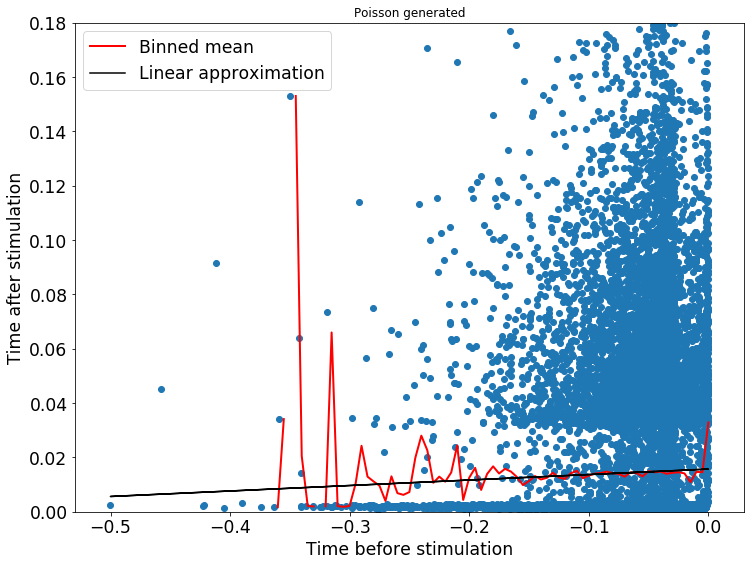

In [339]:
plt.scatter(Z, X)

a, b, c = st.binned_statistic(Z, X, statistic='mean', bins=100)

plt.plot(b[1:], a, c='r', lw=2, label='Binned mean')

plt.ylim(0, .18)

ZZ = np.vstack((Z, np.ones(Z.shape[0]))).T

XX = np.vstack((X, np.ones(X.shape[0]))).T

W = OLS(ZZ, XX)

X_hat = np.dot(ZZ, W)

plt.plot(Z, X_hat[:,0], 'k', label='Linear approximation')

plt.xlabel('Time before stimulation')

plt.ylabel('Time after stimulation')

plt.legend()

plt.title('Poisson generated')

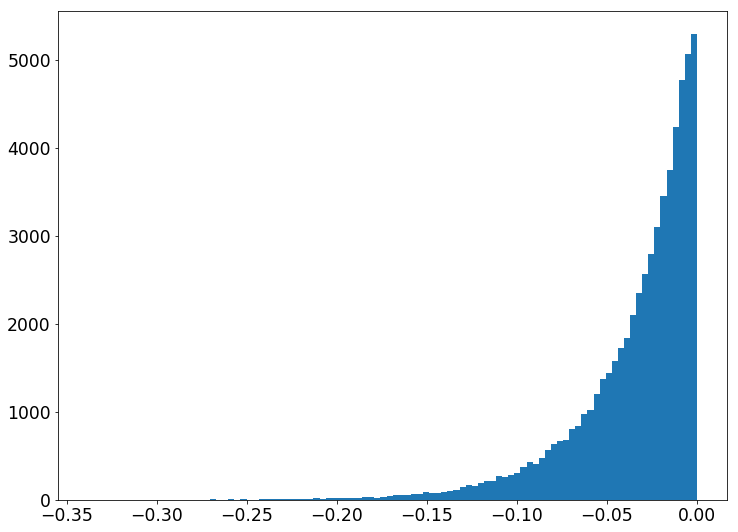

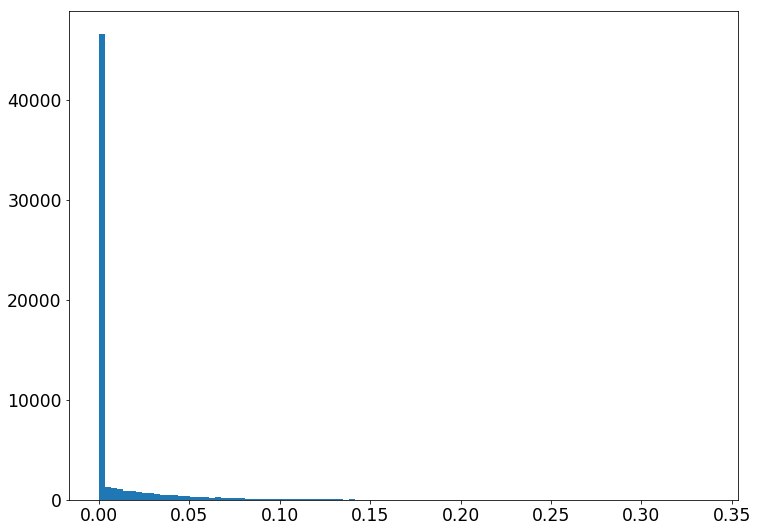

In [298]:
bins = 100#np.arange(-.1, 0, 1e-3)
plt.hist(Z, bins=bins);

plt.figure()
bins = 100#np.arange(0, 0.01, 1e-4)
plt.hist(X, bins=bins);

array([0.00597873, 0.00219727])

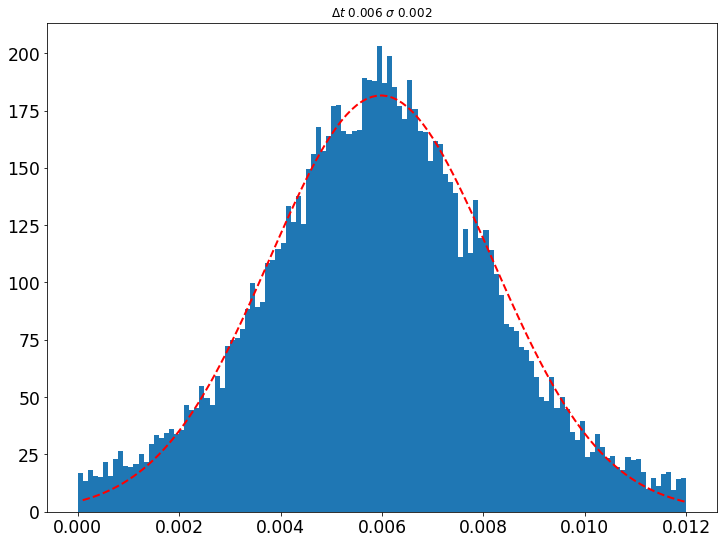

In [283]:
fit_latency(stim_times, y, limit=[0, 12e-3], plot=True)

# Increasing hit chance A -> C

In [292]:
np.random.seed(1234)
results = []
for h in tqdm(np.arange(.1, 1.1, .1)):
    stim_params = {
        'stop_time': 2000, # seconds
        'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
        'stim_isi_min': 30e-3, # minimum inter stimulus interval
    }
    neuron_params = {
        'refractory': 4e-3, # 4 ms
        'latency': 4e-3, # post response delay
        'latency_std': 2e-3,
        'pre_hit_chance': h, # fraction of spikes that are driven by the presynaptic neuron
        'post_rate': 20, # Hz
        'pre_rate': 20, # base rate
        'stim_hit_chance': .3, # fraction of spikes that are driven by the stimulation
        'stim_latency': 2e-3, # latency from stim to pre response
        'stim_latency_std': .3e-3,
        'stop_time': stim_params['stop_time'],
    }
    iv_params = {
        'winsize': 12e-3,
        'latency': 0
    }

    stim_times = generate_stim_times(**stim_params) 
    
    A_spikes, C_spikes = generate_neurons(stim_times, make_post=True, **neuron_params)

    B_spikes = generate_neurons(stim_times, make_post=False, **neuron_params)

    beta_AC = IV(
        x=A_spikes, y=C_spikes, stim_times=stim_times, **iv_params)
    
    beta_BC = IV(
        x=B_spikes, y=C_spikes, stim_times=stim_times, **iv_params)
    
    res = {
        'A_rate': len(A_spikes) / neuron_params['stop_time'], 
        'B_rate': len(B_spikes) / neuron_params['stop_time'], 
        'C_rate': len(C_spikes) / neuron_params['stop_time'],
        'S_rate': len(stim_times) / neuron_params['stop_time'],
        'C_induced_rate': (len(C_spikes) / neuron_params['stop_time']) - neuron_params['post_rate'],
        'beta_AC': beta_AC,
        'beta_BC': beta_BC
    }
    results.append({**stim_params, **neuron_params, **iv_params, **res})
    
results = pd.DataFrame(results)
results

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

,A_rate,B_rate,C_induced_rate,C_rate,S_rate,beta_AC,beta_BC,latency,latency_std,post_rate,pre_hit_chance,pre_rate,refractory,stim_hit_chance,stim_isi_min,stim_latency,stim_latency_std,stim_rate,stop_time,winsize
0,22.6420,22.5950,0.4645,20.4645,15.8100,5.703693,90104.338810,0,0.002,20,0.1,20,0.004,0.3,0.03,0.002,0.0003,30,2000,0.012
1,22.5295,22.6145,2.3965,22.3965,15.8020,13.913033,-7.906198,0,0.002,20,0.2,20,0.004,0.3,0.03,0.002,0.0003,30,2000,0.012
2,22.6125,22.5755,4.2910,24.2910,15.8210,15.523391,35.947103,0,0.002,20,0.3,20,0.004,0.3,0.03,0.002,0.0003,30,2000,0.012
3,22.5920,22.5860,6.1985,26.1985,15.7750,31.819108,5.295677,0,0.002,20,0.4,20,0.004,0.3,0.03,0.002,0.0003,30,2000,0.012
4,22.5870,22.5455,8.0815,28.0815,15.7705,63.643654,3.311774,0,0.002,20,0.5,20,0.004,0.3,0.03,0.002,0.0003,30,2000,0.012
5,22.5270,22.5660,9.9285,29.9285,15.7710,95.841091,-3.113850,0,0.002,20,0.6,20,0.004,0.3,0.03,0.002,0.0003,30,2000,0.012
6,22.5770,22.5700,11.8390,31.8390,15.8355,54.336102,-6.292967,0,0.002,20,0.7,20,0.004,0.3,0.03,0.002,0.0003,30,2000,0.012
7,22.6285,22.5455,13.7925,33.7925,15.7390,76.693428,-9.551128,0,0.002,20,0.8,20,0.004,0.3,0.03,0.002,0.0003,30,2000,0.012
8,22.5935,22.6270,15.6985,35.6985,15.7755,87.441418,-2.557202,0,0.002,20,0.9,20,0.004,0.3,0.03,0.002,0.0003,30,2000,0.012
9,22.5575,22.5295,17.4290,37.4290,15.7420,45.001978,-2.858259,0,0.002,20,1.0,20,0.004,0.3,0.03,0.002,0.0003,30,2000,0.012


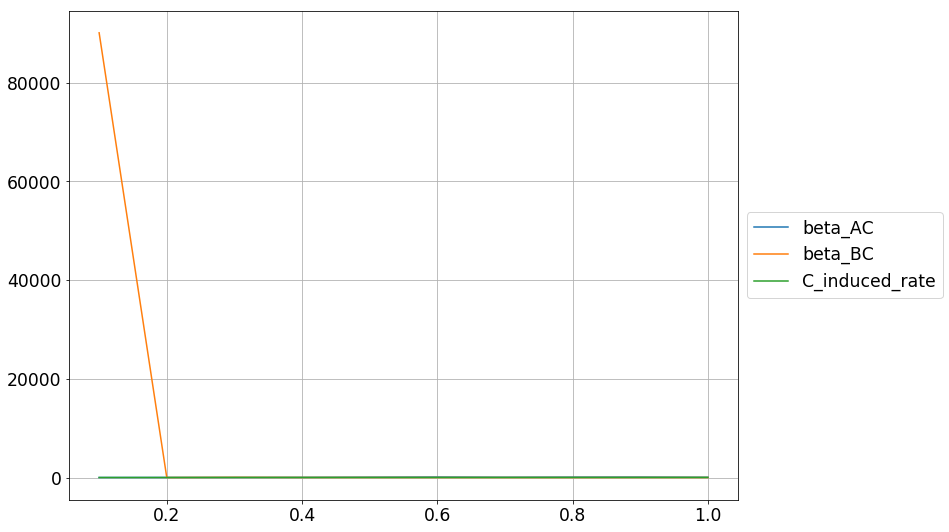

In [293]:
keys = [
#     'A_rate',
#     'B_rate',
#     'C_rate',
#     'S_rate',
    'beta_AC',
    'beta_BC',
    'C_induced_rate'
]

cmap = cm.get_cmap('tab10')
cnt = 0
for key in keys:
    plt.plot(results['pre_hit_chance'], results[key], label=key, color=cmap(cnt))
    cnt += 1
plt.grid(True)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Increasing stop time

In [286]:
results_stop_time = []
for h in tqdm(np.arange(100, 6100, 10)):
    stim_params = {
        'stop_time': h, # seconds
        'stim_rate': 30, # rate of stimulation (gets reduced by pruning for minimum inter stimulus interval)
        'stim_isi_min': 30e-3, # minimum inter stimulus interval
    }
    neuron_params = {
        'refractory': 4e-3, # 4 ms
        'latency': 4e-3, # post response delay
        'latency_std': 2e-3,
        'pre_hit_chance': .5, # fraction of spikes that are driven by the presynaptic neuron
        'post_rate': 5, # Hz
        'pre_rate': 5, # base rate
        'stim_hit_chance': .8, # fraction of spikes that are driven by the stimulation
        'stim_latency': 2e-3, # latency from stim to pre response
        'stim_latency_std': .3e-3,
        'stop_time': stim_params['stop_time'],
    }
    iv_params = {
        'winsize': 12e-3,
        'latency': 0
    }
    
    stim_times = generate_stim_times(**stim_params) 
    
    A_spikes, C_spikes = generate_neurons(stim_times, make_post=True, **neuron_params)

    B_spikes = generate_neurons(stim_times, make_post=False, **neuron_params)

    beta_AC = IV(
        x=A_spikes, y=C_spikes, stim_times=stim_times, **iv_params)
    
    beta_BC = IV(
        x=B_spikes, y=C_spikes, stim_times=stim_times, **iv_params)
    
    res = {
        'A_rate': len(A_spikes) / neuron_params['stop_time'], 
        'B_rate': len(B_spikes) / neuron_params['stop_time'], 
        'C_rate': len(C_spikes) / neuron_params['stop_time'],
        'S_rate': len(stim_times) / neuron_params['stop_time'],
        'C_induced_rate': (len(C_spikes) / neuron_params['stop_time']) - neuron_params['post_rate'],
        'beta_AC': beta_AC,
        'beta_BC': beta_BC
    }
    results_stop_time.append({**stim_params, **neuron_params, **iv_params, **res})
    
results_stop_time = pd.DataFrame(results_stop_time)
results_stop_time.head()

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

,A_rate,B_rate,C_induced_rate,C_rate,S_rate,beta_AC,beta_BC,latency,latency_std,post_rate,pre_hit_chance,pre_rate,refractory,stim_hit_chance,stim_isi_min,stim_latency,stim_latency_std,stim_rate,stop_time,winsize
0,17.140000,17.140000,8.110000,13.110000,15.820000,-55.287874,15.787299,0,0.002,5,0.5,5,0.004,0.8,0.03,0.002,0.0003,30,100,0.012
1,17.436364,17.363636,8.318182,13.318182,16.090909,-38.482810,23.075935,0,0.002,5,0.5,5,0.004,0.8,0.03,0.002,0.0003,30,110,0.012
2,16.900000,16.866667,8.100000,13.100000,15.541667,7.784889,-18.914510,0,0.002,5,0.5,5,0.004,0.8,0.03,0.002,0.0003,30,120,0.012
3,16.915385,17.030769,8.038462,13.038462,15.830769,-13.498900,-19.294830,0,0.002,5,0.5,5,0.004,0.8,0.03,0.002,0.0003,30,130,0.012
4,16.964286,16.964286,8.021429,13.021429,15.707143,64.396009,18.927940,0,0.002,5,0.5,5,0.004,0.8,0.03,0.002,0.0003,30,140,0.012


(0, 100)

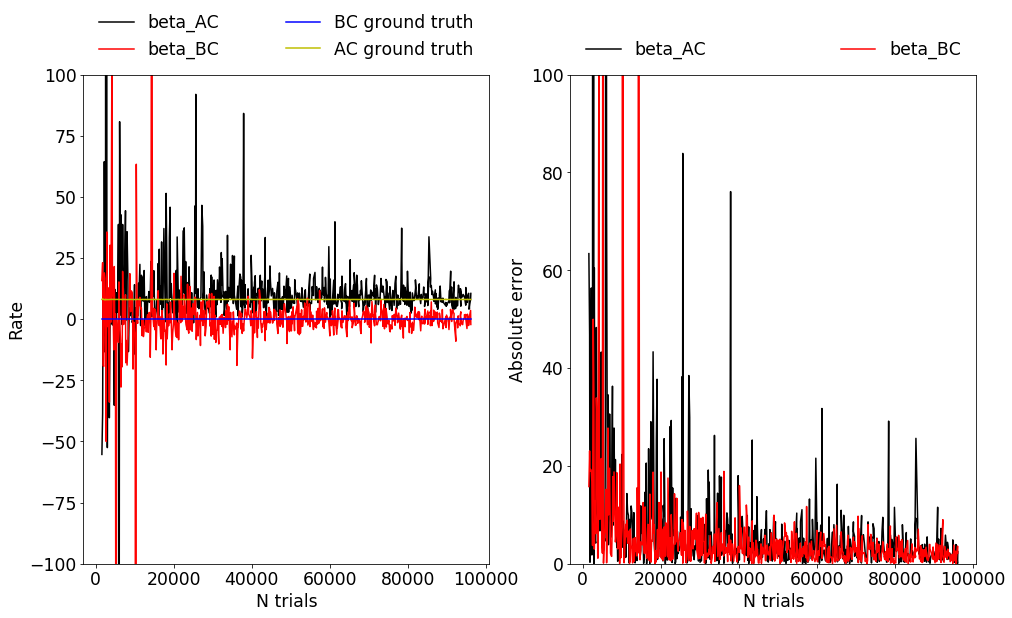

In [287]:
fig, (ax_v, ax_e) = plt.subplots(1, 2, figsize=(16, 9))

ax_v.plot(
    results_stop_time['stop_time'] * results_stop_time['S_rate'], 
    results_stop_time['beta_AC'], 
    color='k')

ax_v.plot(
    results_stop_time['stop_time'] * results_stop_time['S_rate'], 
    results_stop_time['beta_BC'], 
    color='r')

ax_v.plot(
    results_stop_time['stop_time'] * results_stop_time['S_rate'], 
    np.zeros(len(results_stop_time['stop_time'])), 
    label='BC ground truth', color='b')

ax_v.plot(
    results_stop_time['stop_time'] * results_stop_time['S_rate'], 
    results_stop_time['C_induced_rate'], 
    label='AC ground truth', color='y')

ax_e.plot(
    results_stop_time['stop_time'] * results_stop_time['S_rate'], 
    abs(results_stop_time['beta_AC'] - results_stop_time['C_induced_rate']), 
    label='beta_AC', color='k')

ax_e.plot(
    results_stop_time['stop_time'] * results_stop_time['S_rate'], 
    abs(results_stop_time['beta_BC'] - 0), 
    label='beta_BC', color='r')

ax_v.set_xlabel('N trials')
ax_e.set_xlabel('N trials')
ax_e.set_ylabel('Absolute error')
ax_v.set_ylabel('Rate')

ax_v.legend(
    bbox_to_anchor=(0., 1.00, 1., .102), loc=3,
    ncol=2, mode="expand", frameon=False)

ax_e.legend(
    bbox_to_anchor=(0., 1.00, 1., .102), loc=3,
    ncol=2, mode="expand", frameon=False)

ax_v.set_ylim(-100, 100)
ax_e.set_ylim(0, 100)